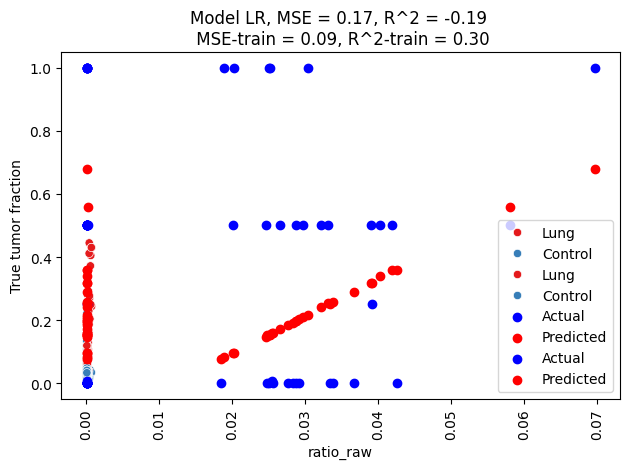

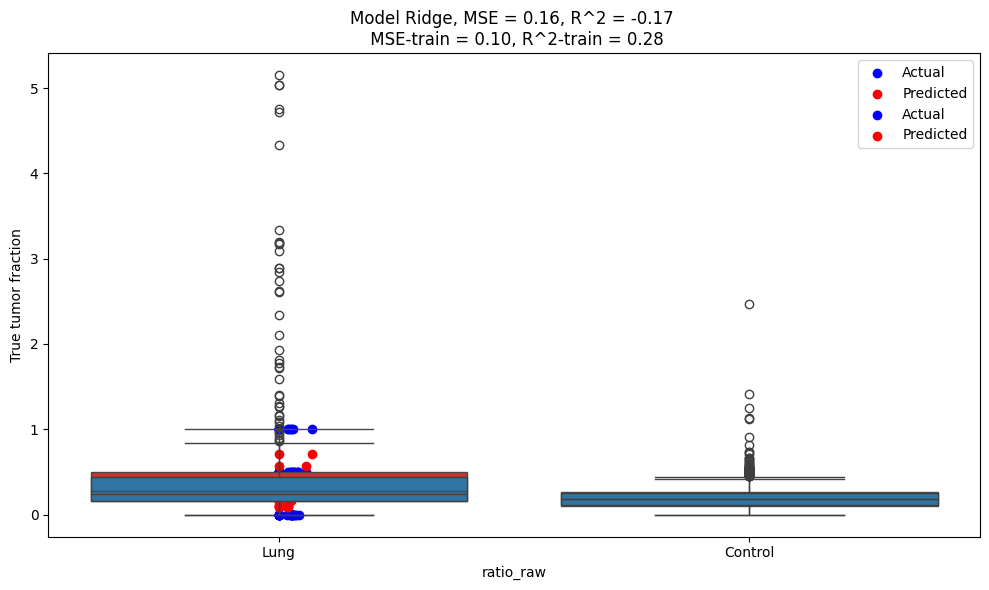

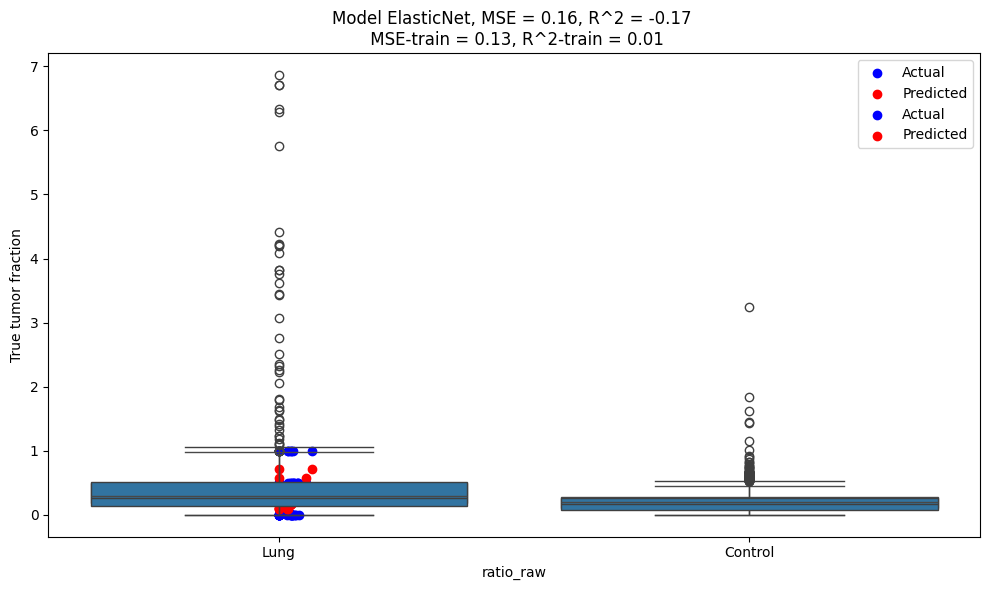

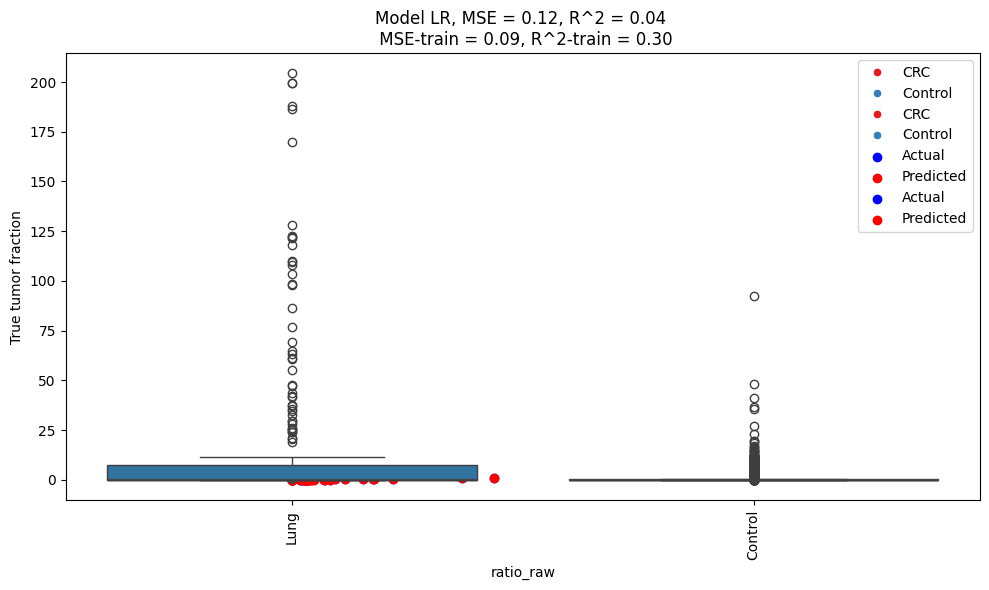

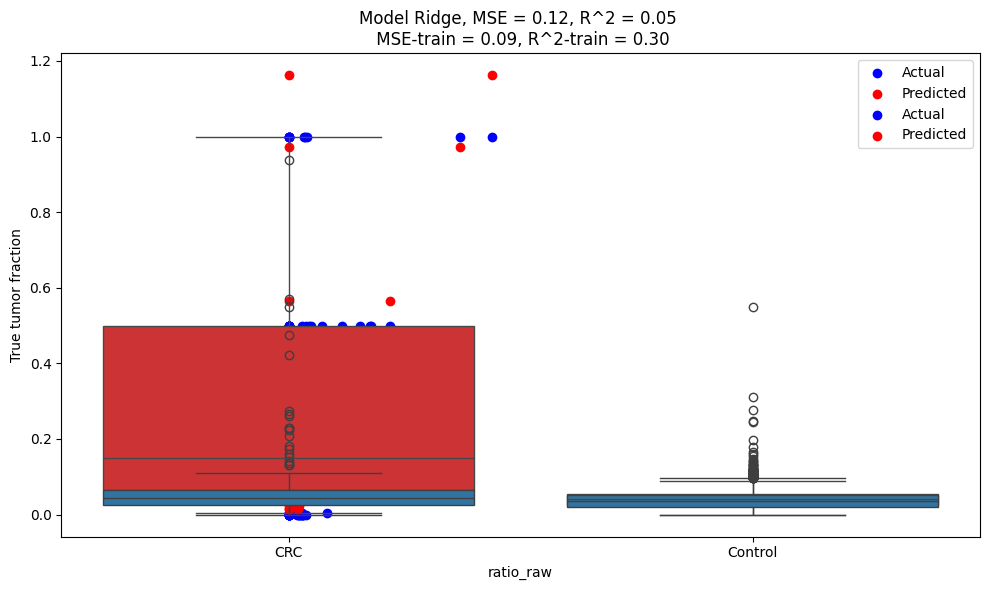

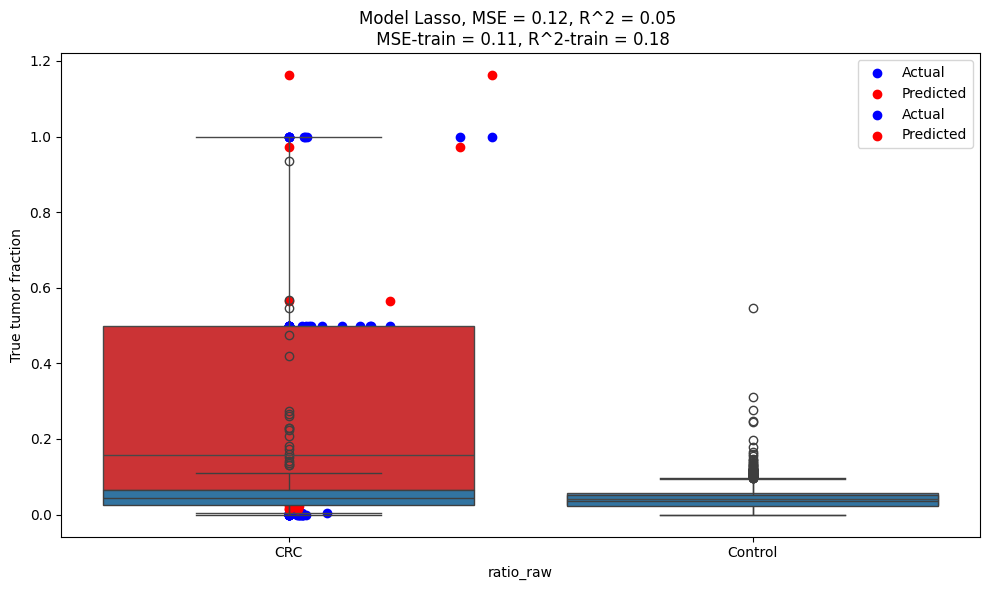

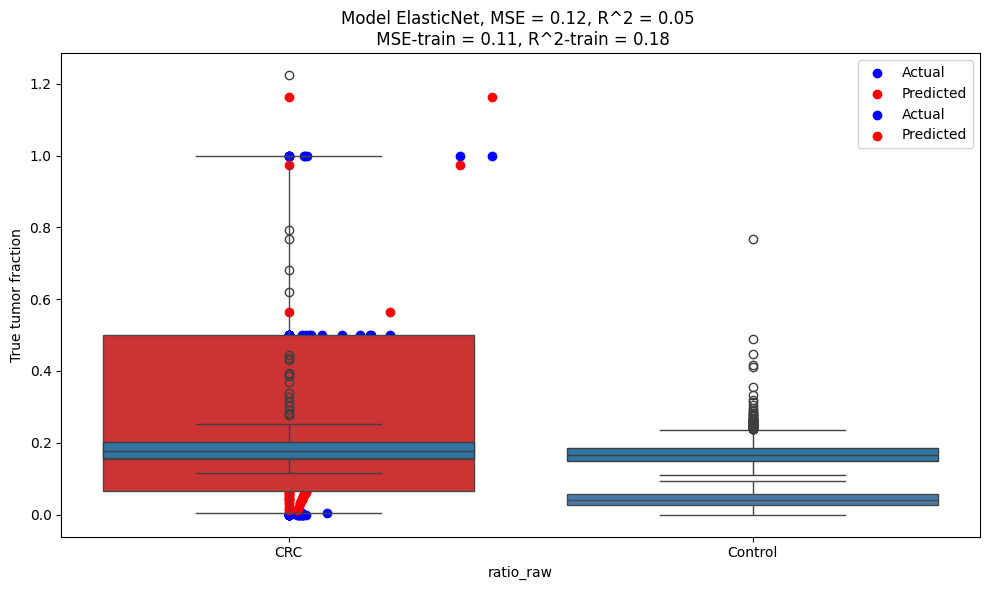

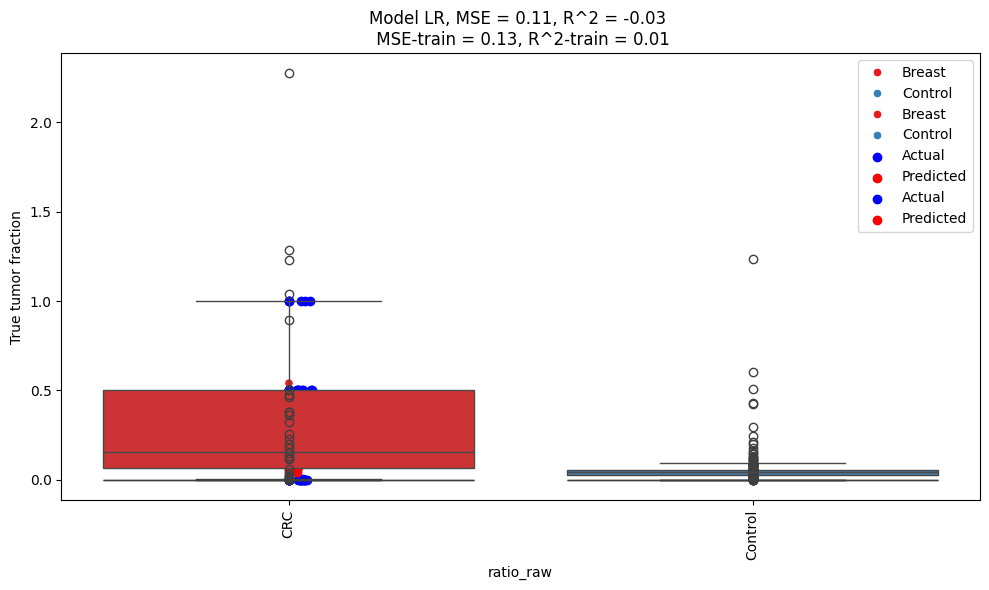

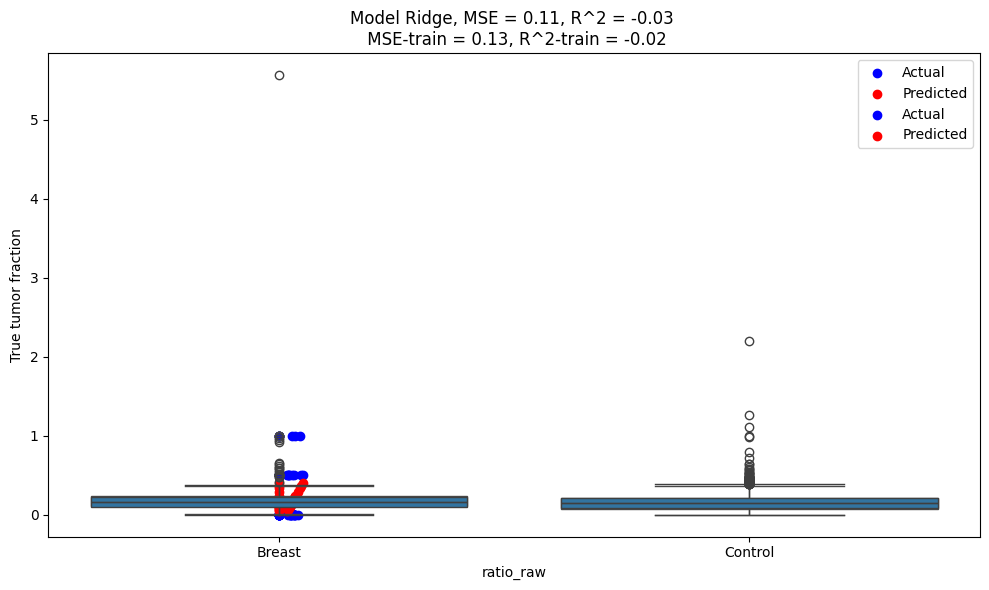

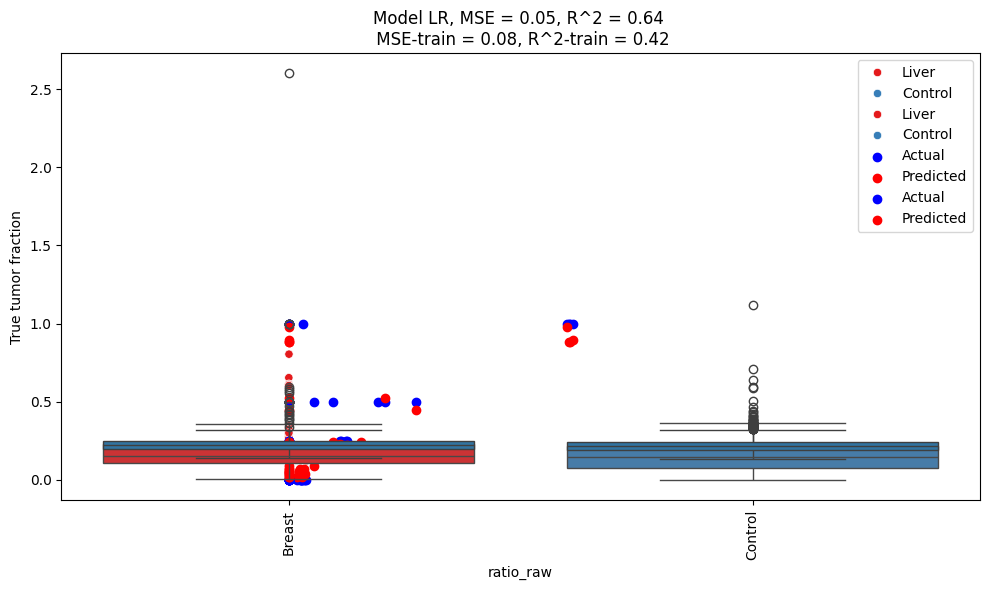

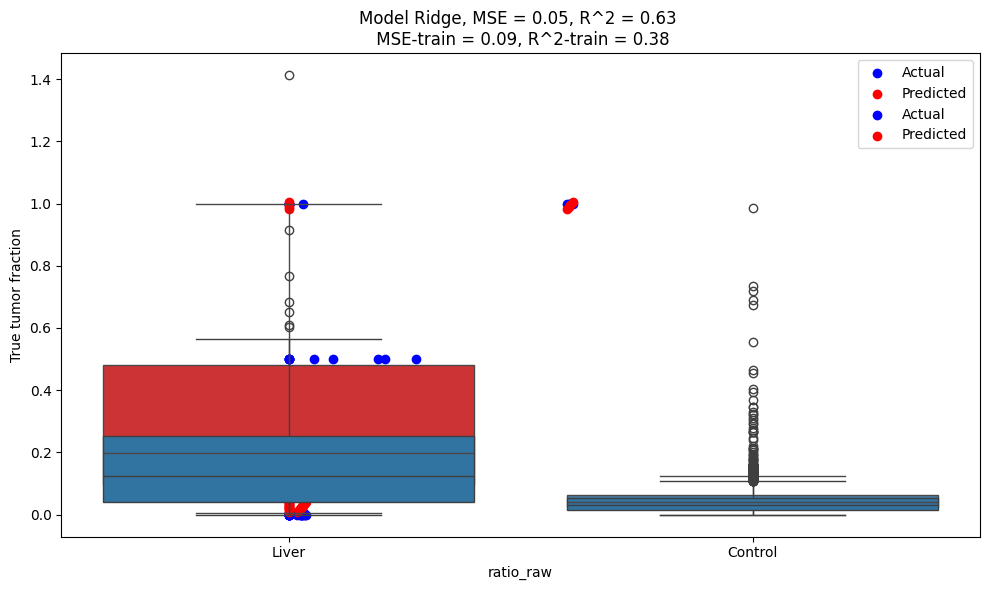

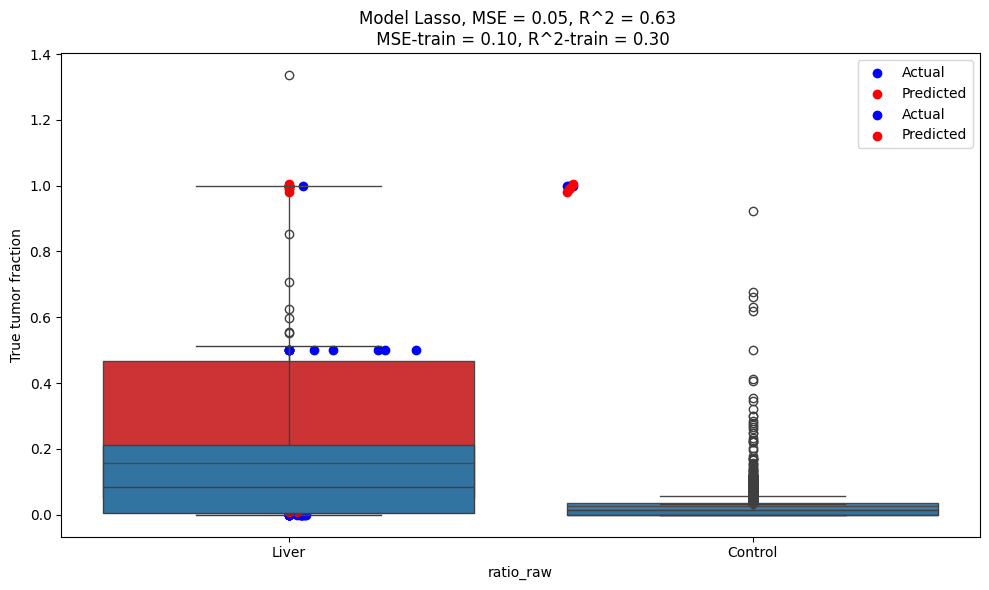

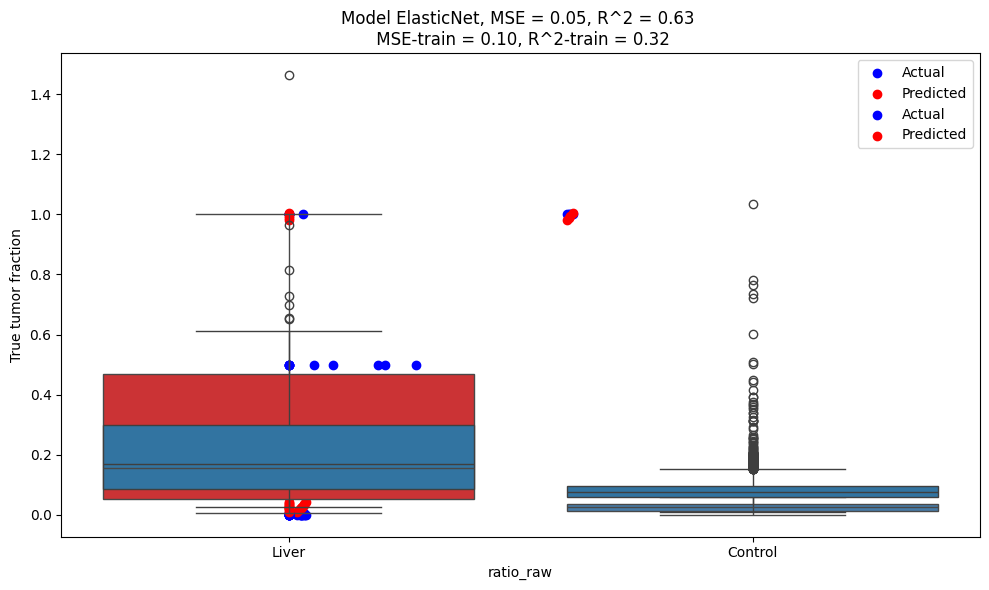

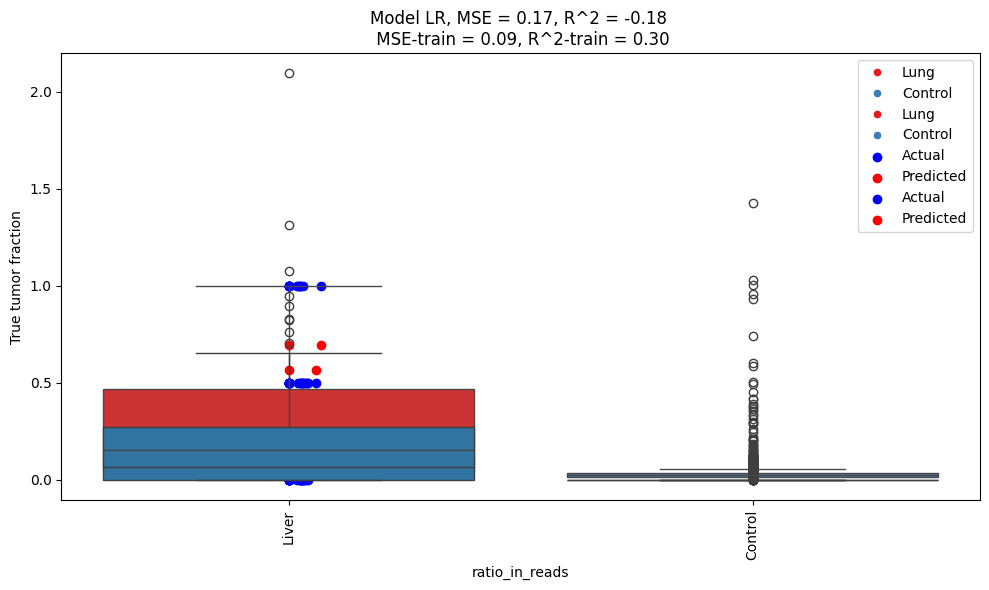

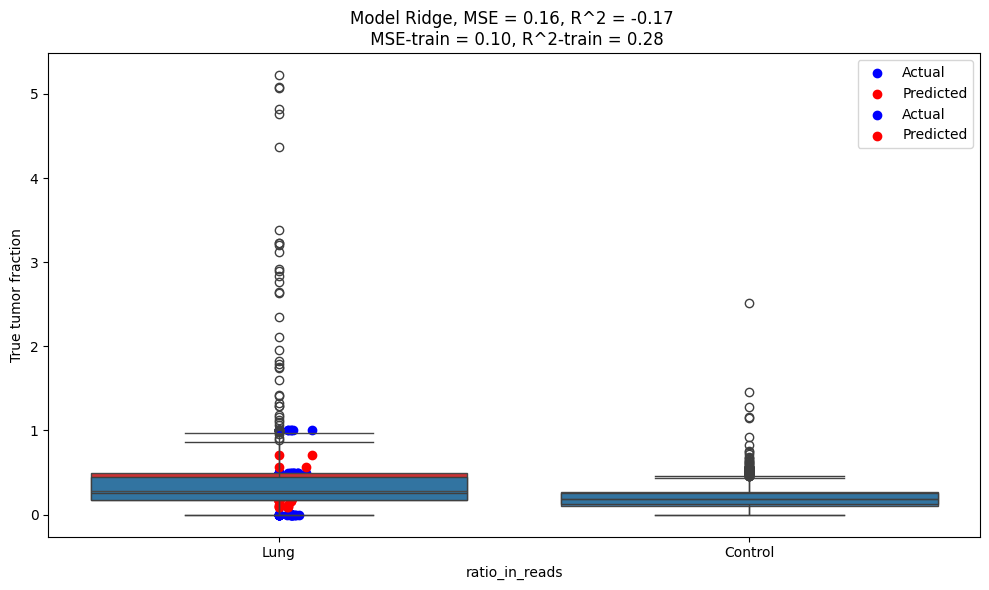

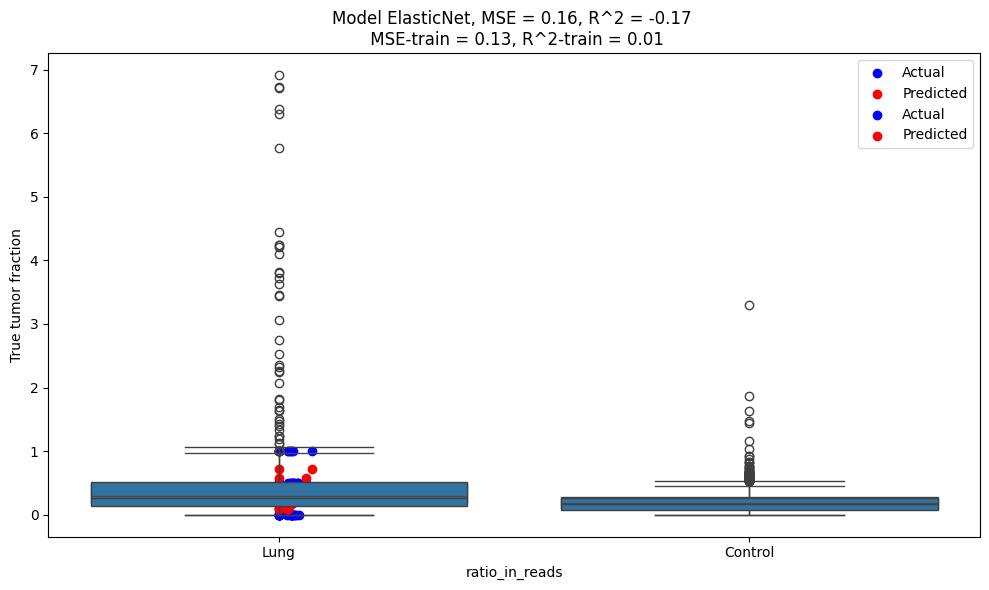

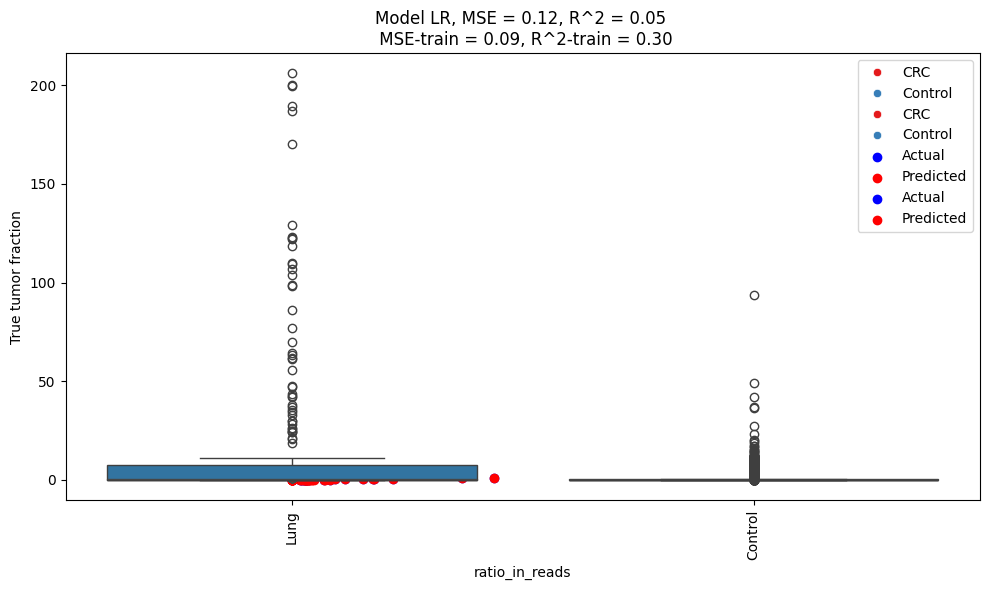

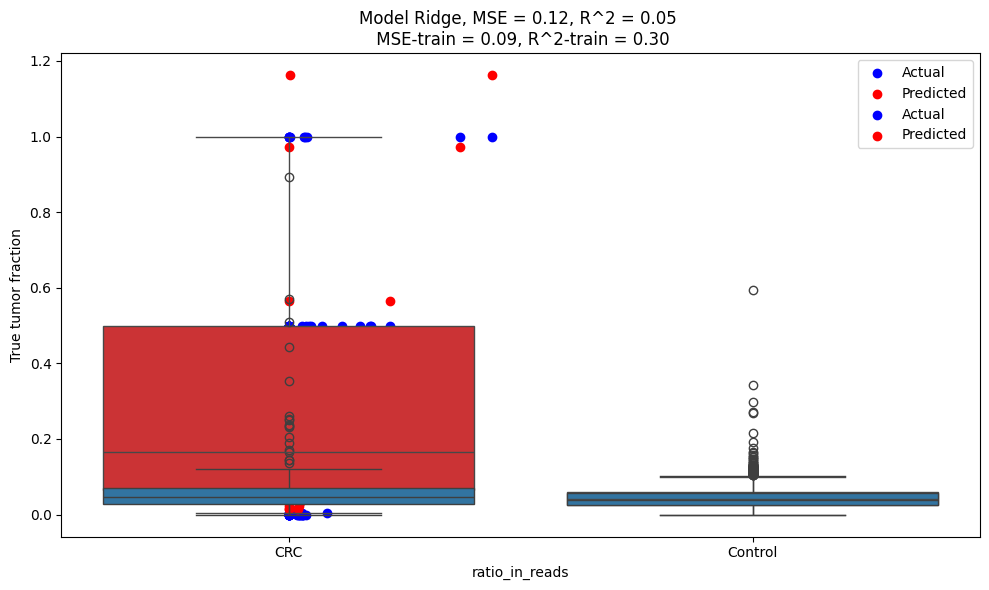

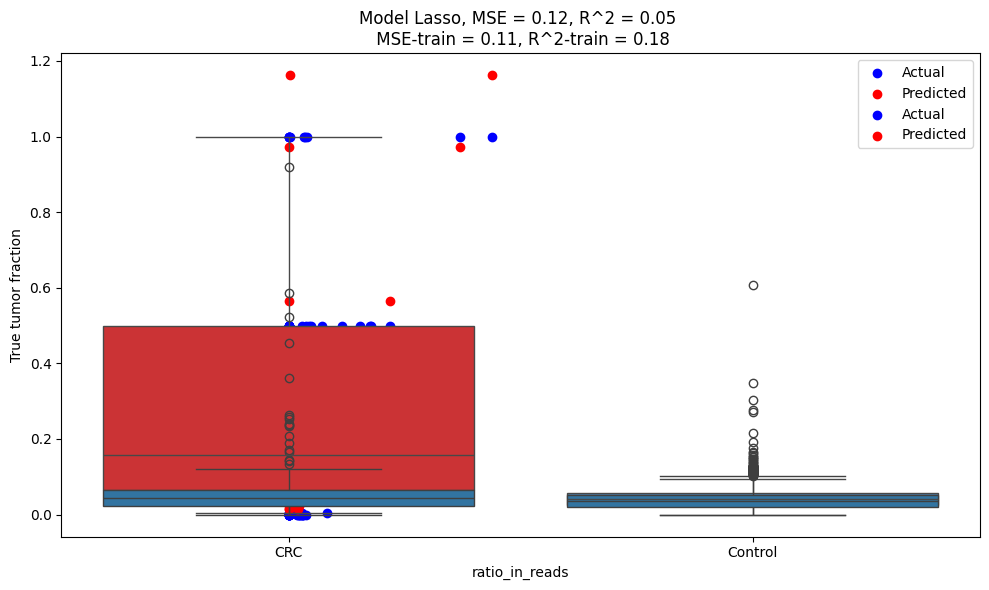

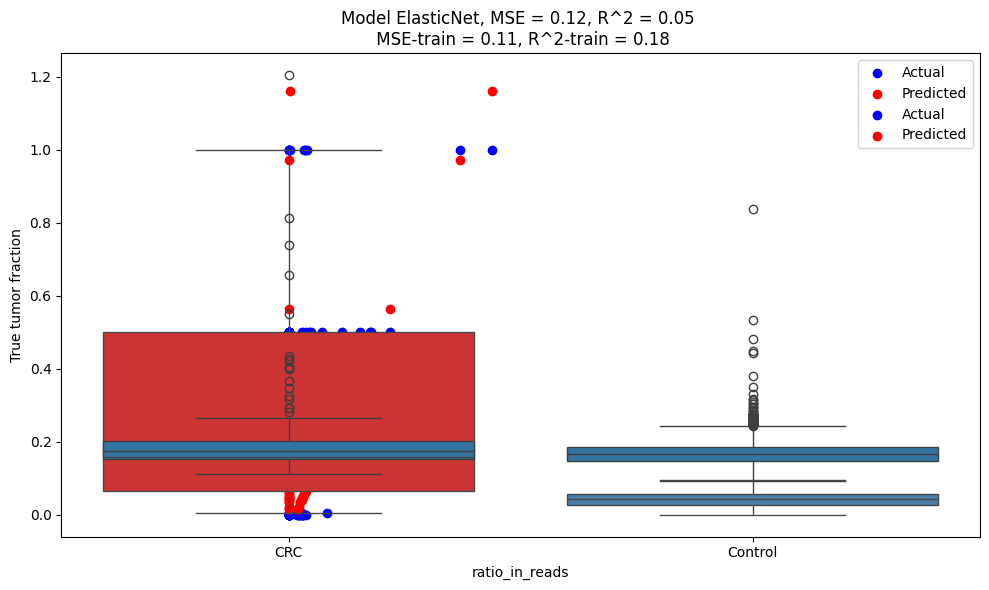

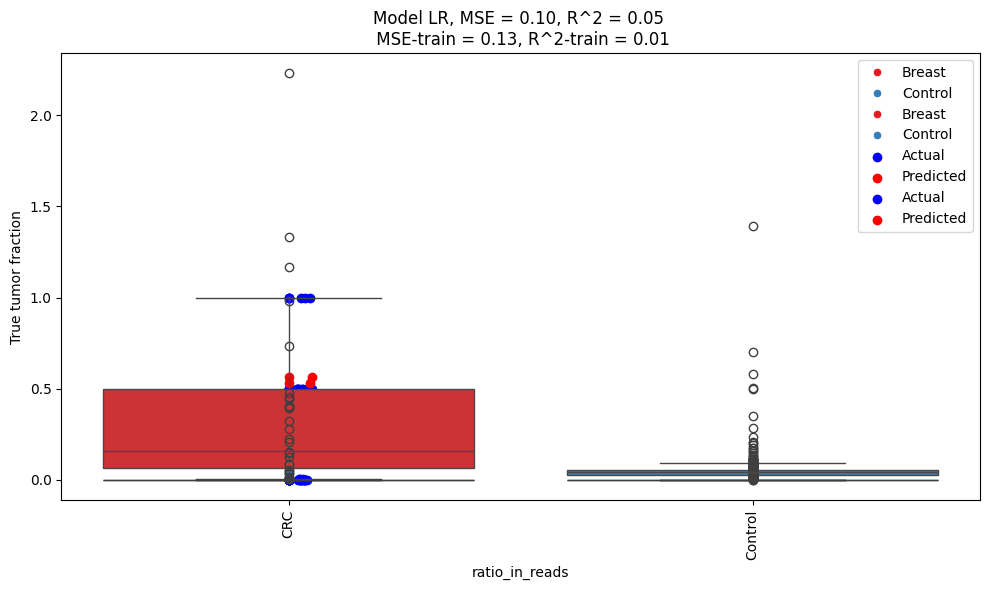

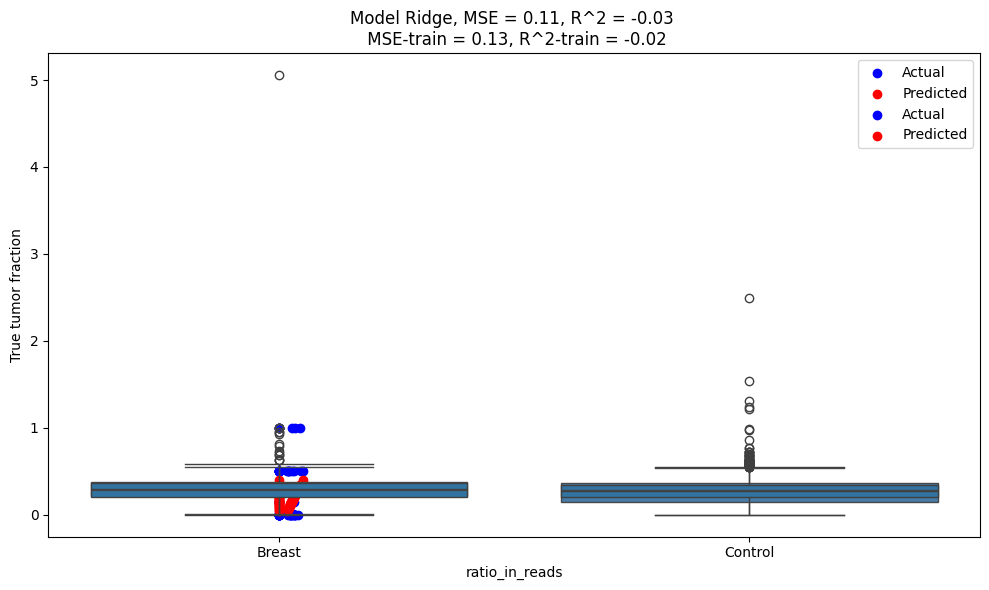

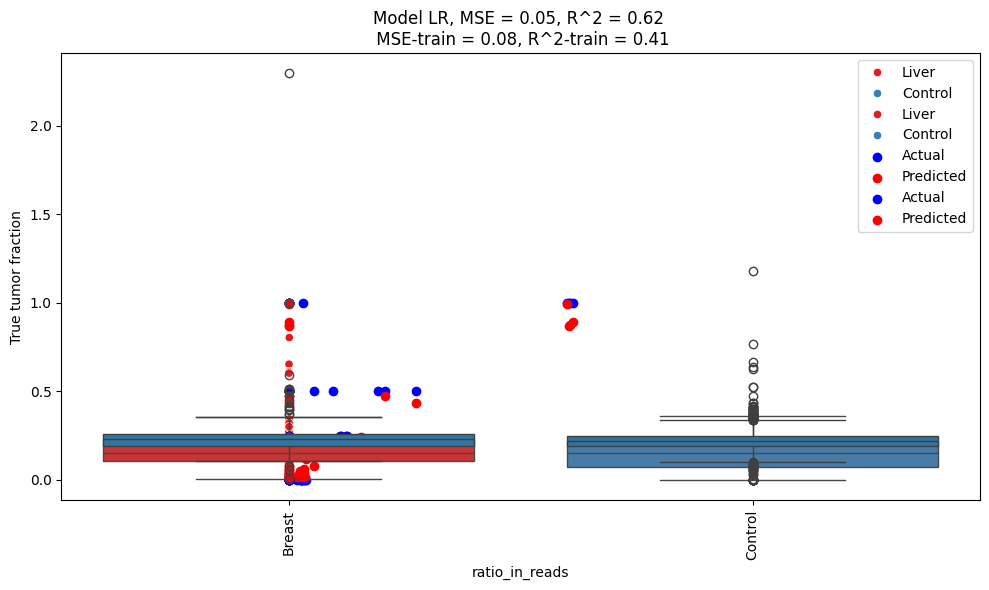

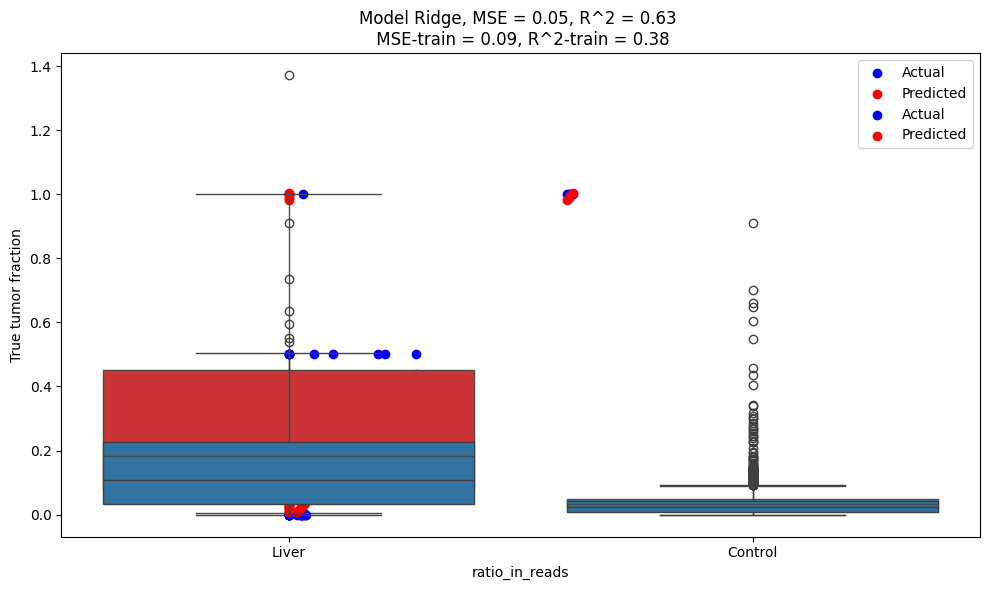

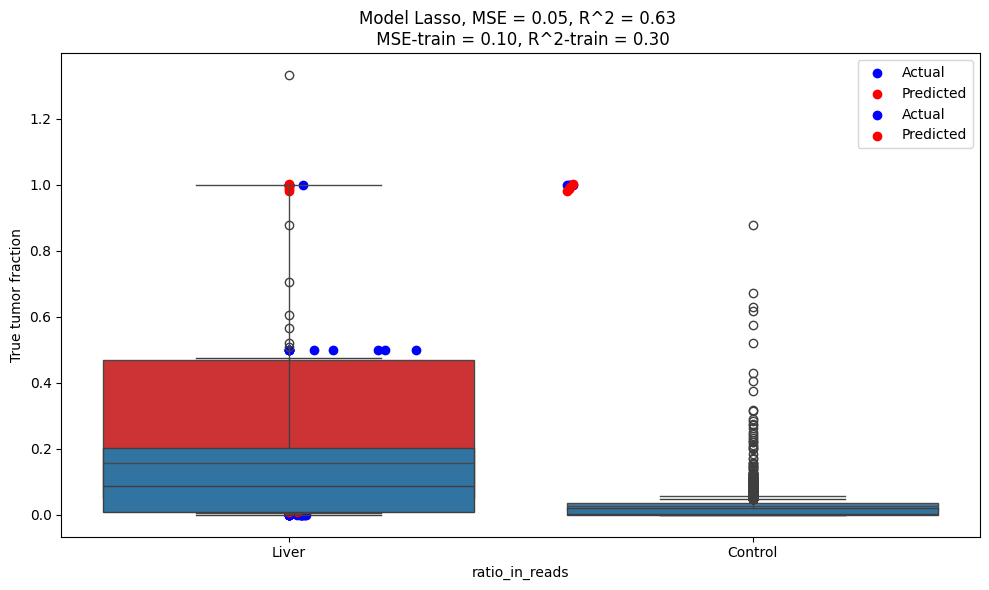

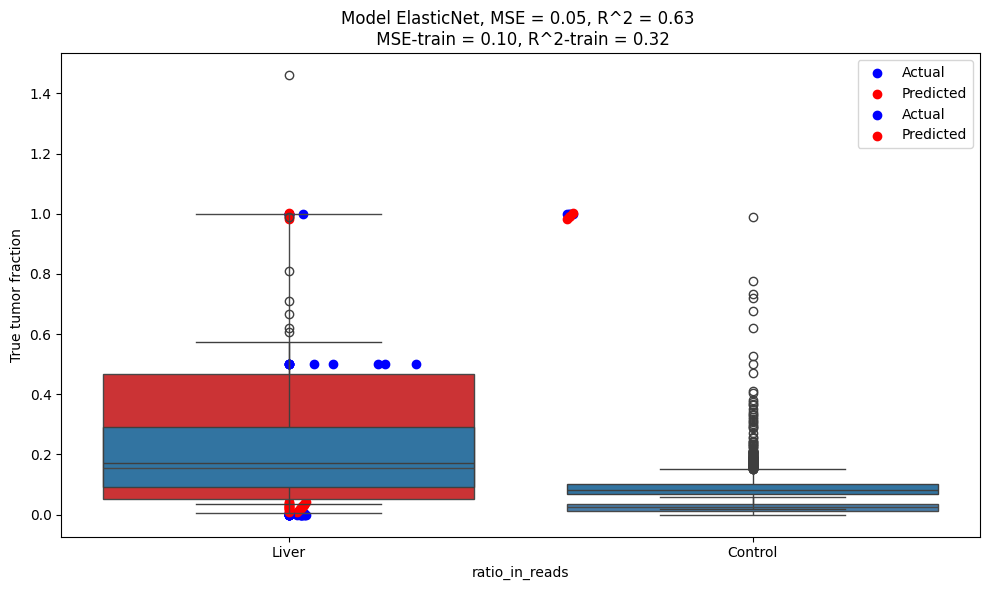

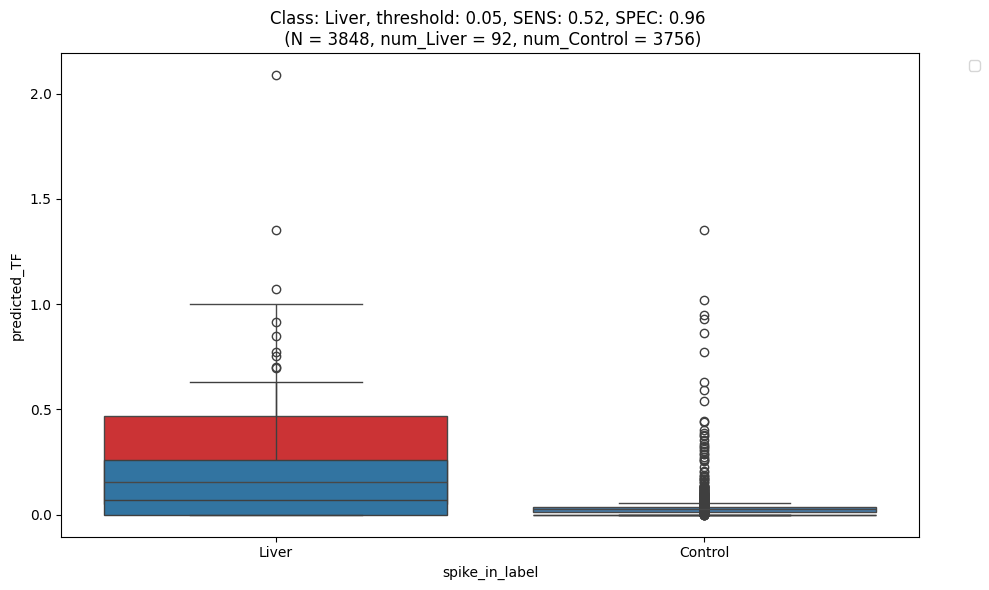

In [ ]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc
import scipy
warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

# outdir = "/media/hieunguyen/HNSD_mini/outdir"
outdir = "/media/hieunguyen/GSHD_HN01/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6
mode = "all"

# selected_candi_features = "ratio_raw"
# input_cancer_class = "Lung"

summarydf = pd.DataFrame()
for selected_candi_features in ["ratio_raw", "ratio_in_reads"]:
    for input_cancer_class in ["Lung", "CRC", "Breast", "Liver"]:
        path_to_main_output = os.path.join(outdir, PROJECT, output_version)
        if mode == "all":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_12_output = os.path.join(outdir, PROJECT, output_version, "12_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hypo_only":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hyper_only":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

        path_to_tf_output = os.path.join(outdir, PROJECT, output_version, "TF_output")
        path_to_01_tf_output = os.path.join(path_to_tf_output, "01_output")

        path_to_savefile = os.path.join(path_to_01_tf_output, "output", input_cancer_class, selected_candi_features)
        os.system(f"mkdir -p {path_to_savefile}")

        metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
        metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

        candidf = pd.read_excel(os.path.join(path_to_08_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))
        ichorcnadf = pd.read_excel("./ichorCNA/metadata_cfDNA_lowpdepth.xlsx")

        # keep only samples that have ichorCNA tumor fractions. 
        ichorcnadf = ichorcnadf[(ichorcnadf["SampleID"].isin(candidf["SampleID"].unique())) & 
                                (ichorcnadf["ichorCNA"].isna() == False)][["SampleID", "ichorCNA"]]

        tf_sampledf = pd.read_csv("./ichorCNA/analytical_LOD_TF.csv")
        tf_sampledf['Label'] = tf_sampledf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])
        tf_sampledf["SampleID"] = tf_sampledf["Sample"].values
        tf_sampledf = tf_sampledf[tf_sampledf["Label"].isin(["Control", input_cancer_class])]
        tf_candi_sampledf = pd.read_excel(os.path.join(path_to_12_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))

        tf_maindf = tf_sampledf[["SampleID", "Label", "Actual tumor_fraction_ichorCNA", "Simulated TF",	"spike-in"]].merge(tf_candi_sampledf[["SampleID", selected_candi_features]], right_on = "SampleID", left_on = "SampleID")
        tf_maindf.columns = ["SampleID", "Label", "ichorCNA", "simulated_TF", "spike_in", selected_candi_features]
        tf_maindf["spike_in_label"] = tf_maindf["simulated_TF"].apply(lambda x: "Control" if x == "Healthy-control" else input_cancer_class)
        convert_ratio = {
            '50' : 0.5, 
            '100': 1, 
            '0.5': 0.005, 
            '25': 0.25, 
            '15': 0.15, 
            '5': 0.5, 
            '1': 1, 
            'HC': 0
        }

        tf_maindf["spike_in_ratio"] = tf_maindf["spike_in"].apply(lambda x: convert_ratio[x])
        maindf = candidf[["SampleID", "Label", selected_candi_features]].merge(ichorcnadf, right_on = "SampleID", left_on = "SampleID")

        #####--------------------------------------------------------#####
        ##### Plot: candi read vs ichorCNA, scatter plot, real TMD data
        #####--------------------------------------------------------#####
        maindf['Label'] = pd.Categorical(maindf['Label'], categories=[input_cancer_class, "Control"])
        pearson_corr = scipy.stats.pearsonr(maindf[selected_candi_features], maindf["ichorCNA"])[0]
        sns.scatterplot(data = maindf, x = selected_candi_features, y = "ichorCNA", hue = "Label", palette = "Set1")
        plt.title(f"Group {input_cancer_class}, pearson correlation: {pearson_corr:.5f}")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_ichorCNA_REPORT4data.svg"), format='svg')
        # plt.show()

        #####--------------------------------------------------------#####
        ##### Plot: candi read vs ichorCNA, scatter plot, LOD data
        #####--------------------------------------------------------#####
        tf_maindf['Label'] = pd.Categorical(tf_maindf['Label'], categories=[input_cancer_class, "Control"])
        pearson_corr = scipy.stats.pearsonr(tf_maindf[selected_candi_features], tf_maindf["ichorCNA"])[0]
        sns.scatterplot(data = tf_maindf, x = selected_candi_features, y = "ichorCNA", hue = "spike_in_label", palette = "Set1")
        plt.xticks(rotation = 90)
        plt.title(f"Group {input_cancer_class}, pearson correlation: {pearson_corr:.5f}")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_ichorCNA_LODdata.svg"), format='svg')
        # plt.show()

        #####--------------------------------------------------------#####
        ##### perform regression with scikit - learn
        #####--------------------------------------------------------#####
        from sklearn.linear_model import LinearRegression
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import mean_squared_error, r2_score
        from sklearn.linear_model import Ridge, Lasso, ElasticNet
        from sklearn.model_selection import GridSearchCV

        all_models = dict()

        # Perform linear regression using both features: ichorCNA and the selected candi-read feature (raw ratio or in read ratio)
        input_features = ["ichorCNA", selected_candi_features] 

        # Split the data into training and testing sets
        dftrain, dftest = train_test_split(tf_maindf, test_size=0.2, random_state=42)

        # Define the features and target variable
        X_train = dftrain[input_features]
        y_train = dftrain["spike_in_ratio"]
        X_test = dftest[input_features]
        y_test = dftest["spike_in_ratio"]

        # Initialize and train the regression model, fit LR with intercept
        model = LinearRegression(fit_intercept = True)
        model.fit(X_train, y_train)

        all_models["LR"] = model

        # Define the models
        ridge = Ridge()
        lasso = Lasso()
        elasticnet = ElasticNet()

        # Define the parameter grids
        ridge_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000], 
                        "fit_intercept": [True, False]}
        lasso_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],
                        "fit_intercept": [True, False]}

        alpha_values = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
        l1_ratios = np.linspace(0, 1, 11) 

        elasticnet_params = {'alpha': alpha_values, 'l1_ratio': l1_ratios}

        # Perform grid search for Ridge
        ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
        ridge_grid.fit(X_train, y_train)
        if ridge_grid.best_estimator_.coef_[0] != 0:
            all_models["Ridge"] = ridge_grid

        # Perform grid search for Lasso
        lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
        lasso_grid.fit(X_train, y_train)
        if lasso_grid.best_estimator_.coef_[0] != 0:
            all_models["Lasso"] = lasso_grid

        # Perform grid search for ElasticNet
        elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2')
        elasticnet_grid.fit(X_train, y_train)
        if elasticnet_grid.best_estimator_.coef_[0] != 0:
            all_models["ElasticNet"] = elasticnet_grid

        for i in all_models.keys():
            # Make predictions
            y_pred_train = all_models[i].predict(X_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)
            # Scale the predictions to 0-1 range
            tf_min = y_pred_train.min()
            tf_max = y_pred_train.max()

            y_pred = all_models[i].predict(X_test)
            y_pred_train = (y_pred_train - tf_min)/(tf_max - tf_min)
            y_pred = (y_pred - tf_min) / (tf_max -tf_min)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Plot the results
            for f in input_features:
                plt.scatter(X_test[f], y_test, color='blue', label='Actual')
                plt.scatter(X_test[f], y_pred, color='red', label='Predicted')
                plt.xlabel(f)
                plt.ylabel("True tumor fraction")
                plt.legend()
                plt.title(f"Model {i}, MSE = {mse:.2f}, R^2 = {r2:.2f} \n MSE-train = {mse_train:.2f}, R^2-train = {r2_train:.2f}")
                plt.tight_layout()
                plt.savefig(os.path.join(path_to_savefile, f"Regression_{selected_candi_features}_model_{i}_feature_{f}_LODdata.svg"), format='svg')
                # plt.show()
            
            #####--------------------------------------------------------#####
            ##### prediction on real REPORT 4 data
            #####--------------------------------------------------------#####
            dftrain["predicted_TF"] = [0 if item < 0 else item for item in y_pred_train]
            dftest["predicted_TF"] = [0 if item < 0 else item for item in y_test]
            loddf = pd.concat([dftrain, dftest], axis = 0)
            loddf['spike_in_label'] = pd.Categorical(loddf['spike_in_label'], categories=[input_cancer_class, "Control"])

            fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(loddf['spike_in_label'].apply(lambda x: 1 if x == input_cancer_class else 0), loddf['predicted_TF'])
            num_cancer = loddf[loddf["spike_in_label"] == input_cancer_class].shape[0]
            num_control = loddf[loddf["spike_in_label"] != input_cancer_class].shape[0]

            aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
            aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

            lod_thres = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
            lod_spec = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
            lod_sen = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

            # Calculate the AUC
            roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=loddf, x="spike_in_label", y="predicted_TF", hue="spike_in_label", palette = "Set1")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, AUC: {roc_auc:.2f}, Sensitivity: {lod_sen:.2f}, Specificity: {lod_spec:.2f}")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_LODdata.svg"), format='svg')
            # plt.show()

            X_real = maindf[input_features].to_numpy()
            y_real = model.predict(X_real)
            y_real = (y_real - tf_min) / (tf_max - tf_min)
            maindf["predicted_TF"] = [0 if item < 0 else item for item in y_real]
            maindf["prediction"] = maindf["predicted_TF"].apply(lambda x: input_cancer_class if x > lod_thres else "Control")
            tp = maindf[(maindf["Label"] == input_cancer_class) & (maindf["prediction"] == input_cancer_class)].shape[0]/maindf[(maindf["Label"] == input_cancer_class)].shape[0]
            tn = maindf[(maindf["Label"] == "Control") & (maindf["prediction"] == "Control")].shape[0]/maindf[(maindf["Label"] == "Control")].shape[0]

            sns.boxplot(data = maindf, x = "Label", y = "predicted_TF")
            plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, SENS: {tp:.2f}, SPEC: {tn:.2f} \n (N = {maindf.shape[0]}, num_{input_cancer_class} = {maindf[maindf['Label'] == input_cancer_class].shape[0]}, num_Control = {maindf[maindf['Label'] == 'Control'].shape[0]})")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_REPORT4data.svg"), format='svg')
            # plt.show()

            loddf.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_LODdata.xlsx"), index = False)
            maindf.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_REPORT4data.xlsx"), index = False)

            tmp = pd.DataFrame(
                {
                "Candi feature": [selected_candi_features],
                "Mode": [mode],
                "Class": [input_cancer_class],
                "Model": [i], 
                "AUC_LOD": [roc_auc], 
                "Sens (LOD)": [lod_sen],
                "Spec (LOD)": [lod_spec], 
                "Threshold LOD": [lod_thres],
                "Sens (REPORT4)": [tp],
                "Spec (REPORT4)": [tn]
                })
            summarydf = pd.concat([summarydf, tmp], axis = 0)
summarydf = summarydf.reset_index().drop("index", axis = 1)
summarydf.to_excel(os.path.join(path_to_01_tf_output, f"summarydf.xlsx"), index = False)


highlight_features = ["AUC_LOD", 
                      "Sens (LOD)",
                      "Spec (LOD)",
                      "Threshold LOD",
                      "Sens (REPORT4)",
                      "Spec (REPORT4)"]
summarydf.style.background_gradient(subset = highlight_features, cmap = "coolwarm").to_excel(os.path.join(path_to_01_tf_output, f"summarydf.color.xlsx"), index = False)


ValueError: cannot insert level_0, already exists

In [5]:
summarydf

,Candi feature,Mode,Class,Model,AUC_LOD,Sens (LOD),Spec (LOD),Threshold LOD,Sens (REPORT4),Spec (REPORT4)
0,ratio_raw,all,Lung,LR,0.703050,0.426966,0.968254,0.353620,0.320388,0.937710
0,ratio_raw,all,Lung,Ridge,0.704833,0.426966,0.952381,0.369031,0.344660,0.921427
0,ratio_raw,all,Lung,ElasticNet,0.704833,0.426966,0.952381,0.369031,0.432039,0.812613
0,ratio_raw,all,CRC,LR,0.876377,0.647059,0.984127,0.080052,0.155556,0.953802
0,ratio_raw,all,CRC,Ridge,0.875630,0.647059,0.984127,0.083447,0.142222,0.960291
0,ratio_raw,all,CRC,Lasso,0.875724,0.647059,0.984127,0.083448,1.000000,0.000000
0,ratio_raw,all,CRC,ElasticNet,0.875630,0.647059,0.984127,0.083447,0.088889,0.992992
0,ratio_raw,all,Breast,LR,0.560847,0.197531,0.984127,0.341086,0.052795,0.965967
0,ratio_raw,all,Breast,Ridge,0.560651,0.197531,0.984127,0.341871,0.037267,0.988997
0,ratio_raw,all,Liver,LR,0.900621,0.681159,0.952381,0.108808,0.532609,0.959265
